In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

import skimage.io
from skimage.transform import resize

from tqdm import tqdm_notebook

In [2]:
### Here we load in all the relevant neural network packages ###
import tensorflow as tf

from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Input, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [10]:
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

def IoU(x,y):
    '''
    version of IoU that uses np.bincount to get the value counts
    
    x and y are both numpy N x M masks
    
    x = proposed mask
    y = ground truth mask
    
    0 for a pixel indicates the mask is blocked, 1 indicates the mask is not blocked.
    In plain English, everywhere that is 1 we can see the cell, everywhere that is 0 we cannot.
    
    We want to calculate the IoU statistic, which is intersection(x,y)/union(x,y) at values where x or y is 1 
    
    By subtracting the proposed mask from 2 x the ground truth mask (i.e. blocked is 0, not blocked is 2),
    then adding 1, we get unique values for each type of overlap situation, plus all values are positive, which
    is required to use np.bincount:
    
INDX  0  1  2  3  4  5  6  7  8  9 10 11

GT    0  0  0  2  2  2  2  2  0  0  0  0
MSK - 0  0  1  1  1  1  0  1  1  0  0  0  
      ----------------------------------
      0  0 -1  1  1  1  2  1 -1  0  0  0
    + 1  1  1  1  1  1  1  1  1  1  1  1
      ----------------------------------
      1  1  0  2  2  2  3  2  0  1  1  1
      
    0: the proposed mask had a pixel, ground truth did not (include in union)   
    1: neither mask had a pixel (don't include)
    2: the proposed mask had a pixed, the ground truth had a pixel (include in intersection and union)
    3: the proposed mask did not have a pixel, the ground truth did (include in union)
    
    np.bincount always has length of np.amax(x) + 1, so we just need to do length checking
    '''
    x = x
    y = y * 2
    
    diff = np.bincount((y - x + 1).flatten())
    diff_len = len(diff)
    
    ### Cacluate the intersection first
    intersection = 0
    if (diff_len >= 3):
        intersection = diff[2]
    
    ### Now calculate the union
    union = intersection
    if diff_len == 4:
        union += diff[3]
    union += diff[0]
        
    if union==0:
        iou = 0 ### default value, we could potentially return blank masks, although GT should never be empty
    else:
        iou = float(intersection) / union

    return iou

def pred_to_binary_mask(pred, threshold):
    tst = np.zeros((pred.shape[0],pred.shape[1]), dtype=np.int8)
    tst[pred >= threshold] = 1
    return tst
    
def calc_iou(pred, gt, threshold):
    pred_mask = pred_to_binary_mask(pred, threshold)
    if (pred_mask.sum()==0) and (gt.sum()==0):
        IoU_value = 1
    elif pred.sum==0 and mask.sum()!=0:
        IoU_value = 0
    else:
        IoU_value = IoU(pred_mask,gt)
    return IoU_value

def calc_avg_precision(pred_mask, gt_mask, threshold, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    ### First calculate the IoU matrix
    iou = calc_iou(pred_mask, gt_mask, threshold)
    
    avg_precision = (iou_thresholds < iou).sum() / len(iou_thresholds)
        
    return avg_precision

class TTA_ModelWrapper_nochop():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in tqdm_notebook(X):
            tmp = x_i
            p0 = self.model.predict(tmp.reshape(1,128,128,1))
            p1 = self.model.predict(np.fliplr(tmp).reshape(1,128,128,1))
#             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
#             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
            p = (p0[0] +
                 np.fliplr(p1[0]) #+
#                  np.flipud(p2[0]) +
#                  np.fliplr(np.flipud(p3[0]))
                 ) / 2#4
            pred.append(p)
        return np.array(pred)
    
class TTA_ModelWrapper_chop():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in tqdm_notebook(X):
            tmp = x_i
            p0 = self.model.predict(tmp.reshape(1,64,64,1))
            p1 = self.model.predict(np.fliplr(tmp).reshape(1,64,64,1))
#             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
#             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
            p = (p0[0] +
                 np.fliplr(p1[0]) #+
#                  np.flipud(p2[0]) +
#                  np.fliplr(np.flipud(p3[0]))
                 ) / 2#4
            pred.append(p)
        return np.array(pred)
    
# class TTA_ModelWrapper_3channel():
#     """A simple TTA wrapper for keras computer vision models.
#     Args:
#         model (keras model): A fitted keras model with a predict method.
#     """

#     def __init__(self, model):
#         self.model = model

#     def predict(self, X):
#         """Wraps the predict method of the provided model.
#         Augments the testdata with horizontal and vertical flips and
#         averages the results.
#         Args:
#             X (numpy array of dim 4): The data to get predictions for.
#         """

#         pred = []
#         for x_i in tqdm_notebook(X):
#             tmp = x_i
#             p0 = self.model.predict(tmp.reshape(1,128,128,3))
#             p1 = self.model.predict(np.fliplr(tmp).reshape(1,128,128,3))
# #             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
# #             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
#             p = (p0[0] +
#                  np.fliplr(p1[0]) #+
# #                  np.flipud(p2[0]) +
# #                  np.fliplr(np.flipud(p3[0]))
#                  ) / 2#4
#             pred.append(p)
#         return np.array(pred)

def load_image(path):
    img = skimage.io.imread(path, as_grey=True)
    return img

def load_mask(path):
    mask = skimage.io.imread(path, as_grey=True)
    mask = mask / 65535
    return mask

def biggenate(x):
    target_image_size = (64,64,1)
    return resize(x, target_image_size, mode='constant', preserve_range=True)

def smallenate(x):
    target_image_size = (101,101)
    return resize(x, target_image_size, mode='constant', preserve_range=True)

def biggenate_zero_pad_nochop(x):
    target_image_size = (128,128,1)
    new_image = np.zeros((target_image_size[0], target_image_size[1], target_image_size[2]), dtype=np.float64)
    new_image[13:114,13:114, 0] = x
    return new_image

def biggenate_zero_pad_chop(x):
    new_img = np.zeros((64,64,1))
    x_ch1, x_ch2 = x.shape
    s = 7
    new_img[s:s+x_ch1,s:s+x_ch2,0] = x
    return new_img

def smallenate_zero_pad(x):
    new_image = x[13:114,13:114]
    return new_image

class LearningRateHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.lr.append(K.eval(self.model.optimizer.lr))

def write_submission_file(submission_file, preds_test_masks, good_test_images):
    with(open(submission_file,'w')) as f:
        f.write('id,rle_mask')

        for i in tqdm_notebook(range(len(good_test_images))):
            image_name = good_test_images[i].split('.')[0]
            pred_mask = preds_test_masks[i,:,:]
            if pred_mask.sum()==0:
                f.write('\n')
                f.write(image_name + ',')
            elif images_test_orig[i].sum()==0:
                f.write('\n')
                f.write(image_name + ',')
            else:
                pred_mask_rle = mask_to_rle(pred_mask)
                f.write('\n')
                f.write(image_name + ',' + ' '.join(list(pred_mask_rle.astype('str'))))

def mask_to_rle(mask):
    """Takes a mask that is nxm, represented as 0 and integers, or as Boolean,
    and converts it to run length encoding."""
    mask = np.transpose(mask)
    mask = mask.astype(np.bool).astype('int')
    mask = mask.reshape(-1)

    dummy = np.insert(mask, 0, 0)
    mask = np.insert(mask, len(mask), 0)

    diff = dummy - mask
    
    diffindx = np.argwhere(diff!=0)
    
    starts = diffindx[::2] + 1 # it is one indexed so need this
    
    runs = diffindx[1::2] - diffindx[::2]
    
    run_length_encoded = np.hstack((starts, runs)).reshape(-1)
    
    return run_length_encoded

def chop_up_images(image_set):
    dummy_output = []
    for img in image_set:
        tst_1 = img[0:50,0:50]
        tst_2 = img[0:50,50:]
        tst_3 = img[50:,0:50]
        tst_4 = img[50:,50:]

        tst_1 = biggenate_zero_pad_chop(tst_1)
        tst_2 = biggenate_zero_pad_chop(tst_2)
        tst_3 = biggenate_zero_pad_chop(tst_3)
        tst_4 = biggenate_zero_pad_chop(tst_4)

        dummy_output.append(tst_1)
        dummy_output.append(tst_2)
        dummy_output.append(tst_3)
        dummy_output.append(tst_4)
    dummy_output = np.array(dummy_output)
    return dummy_output

def isvert(mask):
    mask = mask.squeeze()
    vertuni = np.unique(mask.sum(axis=1))
    vertlen = len(np.unique(mask.sum(axis=1)))
    if ((vertlen==1) and (vertuni[0]!=0) and (vertuni[0]!=101)):
        return True
    else:
        return False
    
def reassemble_chopped(x1, x2, x3, x4):
    result = np.zeros((101,101))
    result[0:50,0:50] = x1[7:7+50,7:7+50]
    result[0:50,50:] = x2[7:7+50,7:7+51]
    result[50:,0:50] = x3[7:7+51,7:7+50]
    result[50:,50:] = x4[7:7+51,7:7+51]
    return result

In [5]:
def unet_model(filter_scaling=16, depth=5, batch_norm_momentum=0.6, input_shape=(128,128,1)):

    input_layer = Input(input_shape)

    conv_initialization_dict = {"activation":'relu', 
                                "padding":'same',
                                "kernel_initializer" : 'he_normal'}

    conv_initialization_dict_no_activation = {"padding":'same',
                                "kernel_initializer" : 'he_normal'}

    conv_dict = {}
    for i in range(1,depth):
        if i==1:
            x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(input_layer)
        else:
            x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(x)
        x = Activation('relu')(x)     
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #     x = Dropout(0.2)(x)
    #     x = Dropout(0.25)(x)
        conv_dict[i] = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #     x = Dropout(0.2)(x)

        x = MaxPooling2D((2,2), padding='same')(conv_dict[i])


    ### The bottom of the network ###
    x = Conv2D((2**(depth-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
    x = BatchNormalization(momentum=batch_norm_momentum)(x)
    x = Conv2D((2**(depth-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
    x = BatchNormalization(momentum=batch_norm_momentum)(x)

    for i in range(depth-1,0,-1):

        x = Conv2DTranspose((2**(i-1)) * filter_scaling, (3,3), strides=(2,2), **conv_initialization_dict)(x)
        x = concatenate([conv_dict[i], x])
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
        x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #     x = Dropout(0.2)(x)
        x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
        if i!=1:
            x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #         x = Dropout(0.2)(x)

    output_layer = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)

    model = Model(input_layer, output_layer)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

### First let's score the main model

Load in the test images, without chopping up for these models to make their predictions.

In [7]:
### Load in the whole list then eliminate those that are bad ###
testdir = '../../../test/'
all_image_files = np.array(os.listdir(filter_directory_list(testdir + 'images/')))
good_test_images = all_image_files

### Load in the images ###
images_test_orig = np.array([load_image(testdir + 'images/' + x) for x in tqdm_notebook(good_test_images)])

### Use this for expansion trained models ###
# images_test = np.array([biggenate(x) for x in tqdm_notebook(images_test_orig)])

### Use this to mean center ###
images_test_orig = np.array([x - x.mean() for x in images_test_orig])

### Use this for zero pad trained models ###
images_test = np.array([biggenate_zero_pad_nochop(x) for x in tqdm_notebook(images_test_orig)])

In [17]:
main_threshold = pd.read_csv('../optimal_parameters_no_vertical_1.csv')

In [18]:
main_threshold.head()

,filter_scaling,depth,batchsize,fold,bn_momentum,final_epoch,random_seed,highest_val_acc,lowest_val_loss,threshold_max,mAP_max,threshold_max_augmentation,mAP_max_augmentation
0,48.0,5.0,64.0,1.0,0.6,31.0,3.898782e+09,0.975430,0.070241,0.653061,0.733676,0.571429,0.750257
1,48.0,5.0,64.0,2.0,0.6,51.0,1.778053e+09,0.980690,0.067851,0.591837,0.791260,0.653061,0.803470
2,48.0,5.0,64.0,3.0,0.6,40.0,1.864850e+09,0.977913,0.072491,0.530612,0.741388,0.571429,0.757712
3,48.0,5.0,64.0,4.0,0.6,38.0,3.302046e+09,0.980593,0.053616,0.551020,0.787918,0.489796,0.790874


In [19]:
main_threshold_p3 = pd.read_csv('../optimal_parameters_no_vertical_2.csv')

In [20]:
main_threshold_p3.head()

,filter_scaling,depth,batchsize,fold,bn_momentum,final_epoch,random_seed,highest_val_acc,lowest_val_loss,threshold_max,mAP_max,threshold_max_augmentation,mAP_max_augmentation
0,48.0,5.0,64.0,1.0,0.6,36.0,4.094707e+09,0.977770,0.065808,0.612245,0.773265,0.551020,0.787018
1,48.0,5.0,64.0,2.0,0.6,33.0,9.414748e+08,0.975223,0.066762,0.734694,0.762468,0.693878,0.778406
2,48.0,5.0,64.0,3.0,0.6,35.0,2.205255e+09,0.975426,0.068618,0.632653,0.743959,0.612245,0.755784
3,48.0,5.0,64.0,4.0,0.6,37.0,3.284034e+09,0.977291,0.067106,0.551020,0.767738,0.551020,0.775964


So let's use the top four of these trials as my "gold standard"

In [ ]:
model_file = '../unet_models/unet_optimal_parameters_m1_to_1_no_vertical_masks_fs_48_d_5_bs_64_bn_0.6_fold_2'
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6, input_shape=(128,128,1))
model.load_weights(model_to_load)

high_threshold_1 = main_threshold['threshold_max_augmentation'][1]
print("Current threshold:",high_threshold_1)

### Do the model predictions
tta = TTA_ModelWrapper_nochop(model)
preds_test_1 = tta.predict(images_test)

preds_test_orig_1 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_1.squeeze())])
preds_test_masks_1 = np.array([pred_to_binary_mask(x, high_threshold_1) for x in tqdm_notebook(preds_test_orig_1)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_1)

In [31]:
model_file = '../unet_models/unet_optimal_parameters_m1_to_1_no_vertical_masks_fs_48_d_5_bs_64_bn_0.6_fold_4'
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6, input_shape=(128,128,1))
model.load_weights(model_to_load)

high_threshold_2 = main_threshold['threshold_max_augmentation'][3]
print("Current threshold:",high_threshold_2)

### Do the model predictions
tta = TTA_ModelWrapper_nochop(model)
preds_test_2 = tta.predict(images_test)

preds_test_orig_2 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_2.squeeze())])
preds_test_masks_2 = np.array([pred_to_binary_mask(x, high_threshold_2) for x in tqdm_notebook(preds_test_orig_2)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_2)

Current threshold: 0.4897959183673469


In [34]:
model_file = '../unet_models/unet_optimal_parameters_m1_to_1_no_vertical_masks_patience_3_fs_48_d_5_bs_64_bn_0.6_fold_1'
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6, input_shape=(128,128,1))
model.load_weights(model_to_load)

high_threshold_3 = main_threshold_p3['threshold_max_augmentation'][0]
print("Current threshold:",high_threshold_3)

### Do the model predictions
tta = TTA_ModelWrapper_nochop(model)
preds_test_3 = tta.predict(images_test)

preds_test_orig_3 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_3.squeeze())])
preds_test_masks_3 = np.array([pred_to_binary_mask(x, high_threshold_3) for x in tqdm_notebook(preds_test_orig_3)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_3)

Current threshold: 0.5510204081632653


In [35]:
model_file = '../unet_models/unet_optimal_parameters_m1_to_1_no_vertical_masks_patience_3_fs_48_d_5_bs_64_bn_0.6_fold_2'
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6, input_shape=(128,128,1))
model.load_weights(model_to_load)

high_threshold_4 = main_threshold_p3['threshold_max_augmentation'][1]
print("Current threshold:",high_threshold_4)

### Do the model predictions
tta = TTA_ModelWrapper_nochop(model)
preds_test_4 = tta.predict(images_test)

preds_test_orig_4 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_4.squeeze())])
preds_test_masks_4 = np.array([pred_to_binary_mask(x, high_threshold_4) for x in tqdm_notebook(preds_test_orig_4)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_4)

Current threshold: 0.6938775510204082


In [36]:
preds_test_sum = preds_test_masks_1 + preds_test_masks_2 + preds_test_masks_3 + preds_test_masks_4

In [39]:
preds_test_masks = (preds_test_sum >= 3).astype(np.int8)

In [ ]:
# write_file = model_file + "_preds_test_masks"
# np.save(write_file, preds_test_masks)

Let's create a submission file just for these.

In [40]:
### Write out the actual submission file ###
submission_file = '../../submissions/unet_m1_to_1_no_vertical_combined_fs_48_d_5_bs_64_bn_0.6_all_folds_threshold_3'
write_submission_file(submission_file, preds_test_masks, good_test_images)

### Now predict the masks for the low model

In [11]:
images_test_chopped = chop_up_images(images_test_orig)

In [12]:
low_threshold = pd.read_csv('./low_coverage_parameter_comparison_1.csv').reset_index()
low_threshold.columns = ("filter_scaling,depth,batch_size,fold,batch_norm_momentum,final_epoch,random_seed,highest_val_acc,lowest_val_loss," + \
                            "threshold_max,mAP_max,threshold_max_class_1,mAP_max_class_1").split(',')

low_threshold = low_threshold[(low_threshold['filter_scaling']==64) & (low_threshold['depth']==5)]

Based on analysis of the effect of a score change for the different coverage categories, we will use 64,5

In [13]:
low_threshold

,filter_scaling,depth,batch_size,fold,batch_norm_momentum,final_epoch,random_seed,highest_val_acc,lowest_val_loss,threshold_max,mAP_max,threshold_max_class_1,mAP_max_class_1
24,64.0,5.0,64.0,1.0,0.6,32.0,2.934359e+09,0.983985,0.055438,0.428571,0.444186,0.469388,0.374783
25,64.0,5.0,64.0,2.0,0.6,44.0,3.113843e+08,0.985429,0.048578,0.346939,0.455233,0.408163,0.369565
26,64.0,5.0,64.0,3.0,0.6,39.0,3.243358e+09,0.984787,0.047106,0.367347,0.454651,0.387755,0.382609
27,64.0,5.0,64.0,4.0,0.6,32.0,4.182245e+09,0.983430,0.049974,0.469388,0.433140,0.469388,0.350435


In [41]:
model_file = './unet_models/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_1'

In [ ]:
model_to_load = model_file
model = unet_model(filter_scaling=64, depth=5, batch_norm_momentum=0.6, input_shape=(64,64,1))
model.load_weights(model_to_load)

high_threshold_chopped_1 = low_threshold['threshold_max'][24]
print("Current threshold:",high_threshold_chopped_1)

### Do the model predictions
preds_test_chopped_1 = model.predict(images_test_chopped)

preds_test_chopped_1 = preds_test_chopped_1.squeeze()

In [42]:
preds_test_orig_chopped_1 = []
for i in range(len(images_test_chopped)//4):
    img1 = preds_test_chopped_1[4*i + 0]
    img2 = preds_test_chopped_1[4*i + 1]
    img3 = preds_test_chopped_1[4*i + 2]
    img4 = preds_test_chopped_1[4*i + 3]
    preds_test_orig_chopped_1.append(reassemble_chopped(img1, img2, img3, img4))
preds_test_orig_chopped_1 = np.array(preds_test_orig_chopped_1)

preds_test_masks_chopped_1 = np.array([pred_to_binary_mask(x, high_threshold_chopped_1) for x in tqdm_notebook(preds_test_orig_chopped_1)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_chopped_1)

In [43]:
model_file = './unet_models/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_2'

In [ ]:
model_to_load = model_file
model = unet_model(filter_scaling=64, depth=5, batch_norm_momentum=0.6, input_shape=(64,64,1))
model.load_weights(model_to_load)

high_threshold_chopped_2 = low_threshold['threshold_max'][25]
print("Current threshold:",high_threshold_chopped_2)

### Do the model predictions
preds_test_chopped_2 = model.predict(images_test_chopped)

preds_test_chopped_2 = preds_test_chopped_2.squeeze()

In [44]:
preds_test_orig_chopped_2 = []
for i in range(len(images_test_chopped)//4):
    img1 = preds_test_chopped_2[4*i + 0]
    img2 = preds_test_chopped_2[4*i + 1]
    img3 = preds_test_chopped_2[4*i + 2]
    img4 = preds_test_chopped_2[4*i + 3]
    preds_test_orig_chopped_2.append(reassemble_chopped(img1, img2, img3, img4))
preds_test_orig_chopped_2 = np.array(preds_test_orig_chopped_2)

preds_test_masks_chopped_2 = np.array([pred_to_binary_mask(x, high_threshold_chopped_2) for x in tqdm_notebook(preds_test_orig_chopped_2)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_chopped_2)

In [45]:
model_file = './unet_models/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_3'

In [ ]:
model_to_load = model_file
model = unet_model(filter_scaling=64, depth=5, batch_norm_momentum=0.6, input_shape=(64,64,1))
model.load_weights(model_to_load)

high_threshold_chopped_3 = low_threshold['threshold_max'][26]
print("Current threshold:",high_threshold_chopped_3)

### Do the model predictions
preds_test_chopped_3 = model.predict(images_test_chopped)

preds_test_chopped_3 = preds_test_chopped_3.squeeze()

In [46]:
preds_test_orig_chopped_3 = []
for i in range(len(images_test_chopped)//4):
    img1 = preds_test_chopped_3[4*i + 0]
    img2 = preds_test_chopped_3[4*i + 1]
    img3 = preds_test_chopped_3[4*i + 2]
    img4 = preds_test_chopped_3[4*i + 3]
    preds_test_orig_chopped_3.append(reassemble_chopped(img1, img2, img3, img4))
preds_test_orig_chopped_3 = np.array(preds_test_orig_chopped_3)

preds_test_masks_chopped_3 = np.array([pred_to_binary_mask(x, high_threshold_chopped_3) for x in tqdm_notebook(preds_test_orig_chopped_3)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_chopped_3)

In [47]:
model_file = './unet_models/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_4'

In [ ]:
model_to_load = model_file
model = unet_model(filter_scaling=64, depth=5, batch_norm_momentum=0.6, input_shape=(64,64,1))
model.load_weights(model_to_load)

high_threshold_chopped_4 = low_threshold['threshold_max'][27]
print("Current threshold:",high_threshold_chopped_4)

### Do the model predictions
preds_test_chopped_4 = model.predict(images_test_chopped)
preds_test_chopped_4 = preds_test_chopped_4.squeeze()

In [48]:
preds_test_orig_chopped_4 = []
for i in range(len(images_test_chopped)//4):
    img1 = preds_test_chopped_4[4*i + 0]
    img2 = preds_test_chopped_4[4*i + 1]
    img3 = preds_test_chopped_4[4*i + 2]
    img4 = preds_test_chopped_4[4*i + 3]
    preds_test_orig_chopped_4.append(reassemble_chopped(img1, img2, img3, img4))
preds_test_orig_chopped_4 = np.array(preds_test_orig_chopped_4)

preds_test_masks_chopped_4 = np.array([pred_to_binary_mask(x, high_threshold_chopped_4) for x in tqdm_notebook(preds_test_orig_chopped_4)])

write_file = '../predicted_masks/' + model_file.split('/')[-1] + "_preds_test_masks"
np.save(write_file, preds_test_masks_chopped_4)

Now let's combine these two.

In [49]:
### Reload in the masks
preds_test_masks_1 = np.load('../predicted_masks/unet_optimal_parameters_m1_to_1_no_vertical_masks_fs_48_d_5_bs_64_bn_0.6_fold_2_preds_test_masks.npy')
preds_test_masks_2 = np.load('../predicted_masks/unet_optimal_parameters_m1_to_1_no_vertical_masks_fs_48_d_5_bs_64_bn_0.6_fold_4_preds_test_masks.npy')
preds_test_masks_3 = np.load('../predicted_masks/unet_optimal_parameters_m1_to_1_no_vertical_masks_patience_3_fs_48_d_5_bs_64_bn_0.6_fold_1_preds_test_masks.npy')
preds_test_masks_4 = np.load('../predicted_masks/unet_optimal_parameters_m1_to_1_no_vertical_masks_patience_3_fs_48_d_5_bs_64_bn_0.6_fold_2_preds_test_masks.npy')

preds_test_masks_chopped_1 = np.load('../predicted_masks/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_1_preds_test_masks.npy')
preds_test_masks_chopped_2 = np.load('../predicted_masks/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_2_preds_test_masks.npy')
preds_test_masks_chopped_3 = np.load('../predicted_masks/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_3_preds_test_masks.npy')
preds_test_masks_chopped_4 = np.load('../predicted_masks/unet_low_model_param_search_fs_64_d_5_bs_64_bn_0.6_fold_4_preds_test_masks.npy')

In [50]:
preds_test_sum = preds_test_masks_1 + preds_test_masks_2 + preds_test_masks_3 + preds_test_masks_4
preds_test_masks = (preds_test_sum >= 2).astype(np.int8)

preds_test_sum_chopped = preds_test_masks_chopped_1 + preds_test_masks_chopped_2 + preds_test_masks_chopped_3 + preds_test_masks_chopped_4
preds_test_masks_chopped = (preds_test_sum_chopped >= 2).astype(np.int8)

In [65]:
main_masks = preds_test_masks
# low_masks = preds_test_masks_chopped
low_masks = np.load('../unet_models/unet_subdivide_images_1_preds_test_masks.npy')

In [66]:
main_masks_coverage = main_masks.sum(axis=(1,2)) / (101 * 101)

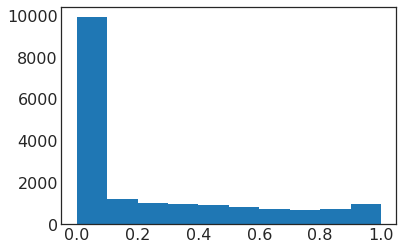

In [67]:
plt.hist(main_masks_coverage); plt.show()

In [69]:
combined_masks = []
counter = 0
for i in range(len(main_masks)):
    if ((main_masks_coverage[i] > 0.0) and (main_masks_coverage[i] <= 0.1)):
        combined_masks.append(low_masks[i])
        counter += 1
#         print(i)
    else:
        combined_masks.append(main_masks[i])
combined_masks = np.array(combined_masks)

In [70]:
submission_file = '../../submissions/unet_combined_1_threshold_0.1_original_subdivided_mask'
write_submission_file(submission_file, combined_masks, good_test_images)

In [60]:
combined_masks.shape

(18000, 101, 101)

In [55]:
main_masks.shape

(18000, 101, 101)

In [56]:
low_masks.shape

(18000, 101, 101)

In [29]:
images_test_chopped.shape

(72000, 64, 64, 1)

In [51]:
preds_test_masks_chopped_1.shape

(18000, 101, 101)

In [31]:
preds_test_chopped_4.shape

(72000, 64, 64)

In [40]:
preds_test_orig_chopped_1.shape, preds_test_orig_chopped_2.shape, preds_test_orig_chopped_3.shape, preds_test_orig_chopped_4.shape

((18000, 101, 101), (18000, 101, 101), (18000, 101, 101), (18000, 101, 101))